## 패키지 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# 회귀 트리 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

# 정규화, 학습 및 테스트 데이터세트 분리
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

%matplotlib inline

## 공통 함수 생성
* 데이터 프레임 생성 모듈 
* 피처 데이터셋트과 레이블 데이터 셋 리턴

In [2]:
def get_dataframe(fnc: object):
  """
  함수를 인자로 받아 데이터셋를 DataFrame으로 리턴
  """
  arr = fnc(return_X_y = False)
  result_df = pd.DataFrame(data = arr.data, columns =arr.feature_names)
  result_df['TARGET'] = arr.target
  return result_df


def get_feature_label_data(df):
  """
  데이터 프레임을 인자로 받아 Feature , Label셋으로 리턴
  """
  X_data = df.drop(labels='TARGET', axis=1, inplace = False, errors='ignore')
  y_target = df['TARGET']
  # train_test_split()함수는 nd.array타입으로 넘겨줘야 하므로 
  # 최종적으로 리턴시에 .values혹은 to_numpy()로 배열로 바꾸어 넘겨주어야 함.
  return X_data.values, y_target.values

def main_process(fnc: object):
  df = get_dataframe(fnc)
  X, y = get_feature_label_data(df)
  return X, y

### 유방암 데이터셋을 이용한 Logistic Regression

#### 데이터 프레임 로드 및 피처 및 레이블 데이터 

In [3]:
df = get_dataframe(load_breast_cancer)
X, y = get_feature_label_data(df)

display(df.info(), df.shape)
print(df.describe())
display(type(X), type(y))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

None

(569, 31)

       mean radius  mean texture  ...  worst fractal dimension      TARGET
count   569.000000    569.000000  ...               569.000000  569.000000
mean     14.127292     19.289649  ...                 0.083946    0.627417
std       3.524049      4.301036  ...                 0.018061    0.483918
min       6.981000      9.710000  ...                 0.055040    0.000000
25%      11.700000     16.170000  ...                 0.071460    0.000000
50%      13.370000     18.840000  ...                 0.080040    1.000000
75%      15.780000     21.800000  ...                 0.092080    1.000000
max      28.110000     39.280000  ...                 0.207500    1.000000

[8 rows x 31 columns]


numpy.ndarray

numpy.ndarray

#### 유방암환자의 결정값 분포
* 정규화된 분포의 데이터인 경우 예측확률이 높으므로, 정규화의 필요성을 확인키 위해.**굵은 텍스트**

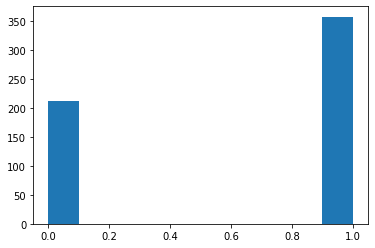

In [4]:
plt.hist(df['TARGET'], bins = 10)
plt.show()

#### 정규화 및 학습및 테스트 데이터셋 분리 

In [5]:
def scale_train_test_split(X,y):
  """
  피처와 레이블 값을 받아 StandardScaler정규화 후 스케일링한 데이터셋을 이용해 
  학습 및 테스트 데이터 분리
  """
  # StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
  # LogisticRegresssion의 경우에 StandardScaler()를 이용해 정규화하는 예측 성능에 유리
  scaler = StandardScaler()
  data_scaled = scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(data_scaled, y, test_size = .3, random_state=0)
  return X_train, X_test, y_train, y_test, data_scaled

In [6]:
X_train, X_test, y_train, y_test, data_scaled = scale_train_test_split(X, y)

In [7]:
display(X_train.shape, X_test.shape)

(398, 30)

(171, 30)

#### 정확도 및 ROC AUC점수 평가

In [8]:
def log_reg_evaluate(model, X_train, X_test, y_train, y_test):
  """
  해당 모델에 대한 로지스틱 회귀 평가
  """
  display(model.__class__.__name__)
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  # accuracy, roc_auc 
  print("accuracy : {0:.3f}".format(accuracy_score(y_test, preds)))
  print("roc auc score : {0:.3f}".format(roc_auc_score(y_test, preds)))

In [9]:
# 로지스틱 회귀를 이용하여 학습 및 예측 수행. 
lr_clf = LogisticRegression()
log_reg_evaluate(lr_clf, X_train, X_test, y_train, y_test)

'LogisticRegression'

accuracy : 0.977
roc auc score : 0.972


#### GridSearchCV로 하이퍼 파라미터 튜닝

In [10]:
def tuning_logisticReg(model, params: dict, cvs: list):
  """
  Logistic Regression을 위한 하이퍼 파라미터 튜닝 (l2, l1규제 및 alpha값)
  """
  for cv in cvs:
    grid_clf = GridSearchCV(estimator = model, param_grid=params, scoring='accuracy', cv = cv)
    grid_clf.fit(data_scaled, y)
    print("최적 하이퍼 파라미터 : {0} , 최적 평균 정확도 : {1:.3f}".format(grid_clf.best_params_, grid_clf.best_score_))

In [11]:
# C값이 작을수록 규제강도가 큼을 유의
params={'penalty':['l2', 'l1'],'C':[0.01, 0.1, 1, 1, 5, 10]}
cvs = [3, 5, 7, 10]

# Tuning for Hyper parameter
tuning_logisticReg(lr_clf, params=params, cvs= cvs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'} , 최적 평균 정확도 : 0.975


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'} , 최적 평균 정확도 : 0.981


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'} , 최적 평균 정확도 : 0.981


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'} , 최적 평균 정확도 : 0.981


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'} , 최적 평균 정확도 : 0.981

In [12]:
# 위에서 나온 최적 파라미터를 이용한 재수행
lr_clf = LogisticRegression(penalty='l2',C=1.0)
log_reg_evaluate(lr_clf, X_train, X_test, y_train, y_test)

'LogisticRegression'

accuracy : 0.977
roc auc score : 0.972


### 보스톤 집값 문제를 통한 회귀 트리

#### 데이터 세트 로드 및 학습,레이블 데이터 분리

In [13]:
# 보스턴 데이터 세트 로드
df = get_dataframe(load_boston)
X, y = get_feature_label_data(df)

display(df.info(), df.shape)
display(df.describe())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  TARGET   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


None

(506, 14)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### RandomForest Regressor를 통한 RMSE 평가 

In [14]:
rf = RandomForestRegressor(n_estimators=1000, random_state=0)
neg_mse_scores = cross_val_score(rf, X, y,  scoring='neg_mean_squared_error', cv =5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_scores = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_scores))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.93 -13.06 -20.53 -46.31 -18.8 ]
 5 교차 검증의 개별 RMSE scores :  [2.82 3.61 4.53 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.420 


In [15]:
def get_model_cv_prediction(model, X_data, y_target):
  """
  회귀모델의 피처 데이터와 레이블 데이터를 인자로 받아서 
  RMSE에 대한 평균값 및 개별 RMSE값 구하기 
  """
  neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv = 5)
  rmse_scores = np.sqrt(-1 * neg_mse_scores)
  avg_scores = np.mean(rmse_scores)
  
  print('##### ',model.__class__.__name__, ' #####')
  print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
  print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
  print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_scores))

In [16]:
# 수행
get_model_cv_prediction(rf, X, y)

#####  RandomForestRegressor  #####
 5 교차 검증의 개별 Negative MSE scores:  [ -7.93 -13.06 -20.53 -46.31 -18.8 ]
 5 교차 검증의 개별 RMSE scores :  [2.82 3.61 4.53 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.420 


#### 사이킷런의 여러 회귀 트리 클래스를 이용하여 회귀 예측 

In [18]:
df_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(n_estimators=1000, random_state=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

models = [df_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
for model in models:
  get_model_cv_prediction(model, X, y)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 개별 Negative MSE scores:  [-11.94 -36.25 -29.63 -47.23 -65.56]
 5 교차 검증의 개별 RMSE scores :  [3.46 6.02 5.44 6.87 8.1 ]
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 개별 Negative MSE scores:  [ -7.93 -13.06 -20.53 -46.31 -18.8 ]
 5 교차 검증의 개별 RMSE scores :  [2.82 3.61 4.53 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.420 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 개별 Negative MSE scores:  [ -7.27 -14.11 -19.16 -39.33 -15.27]
 5 교차 검증의 개별 RMSE scores :  [2.7  3.76 4.38 6.27 3.91]
 5 교차 검증의 평균 RMSE : 4.201 
[13:52:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:16] WARNING: /workspace/src/objective/

#### Feature Importance 시각화
* 회귀 트리는 선형 회귀의 계수 대신, 피처 중요도로 상대적 중요도를 알수 있다.

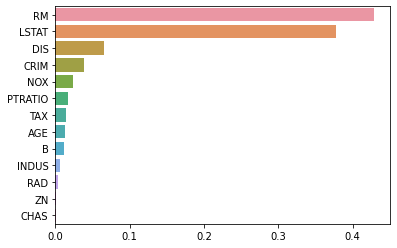

In [17]:
import seaborn as sns
rf_reg = RandomForestRegressor(n_estimators=1000)
columns = df.drop('TARGET', inplace=False, axis=1).columns

rf_reg.fit(X, y)
feature_series = pd.Series(data = rf_reg.feature_importances_, index = columns)
feature_series = feature_series.sort_values(ascending=False)

sns.barplot(x=feature_series, y = feature_series.index)

#### 오버피팅을 시각화 하기 위해 한개의 피처 RM과 타겟값 PRICE기반으로 회귀 예측 수행
* 회귀 트리를 단순화하는것을 고려를 해봐야 함(오버피팅의 문제)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(100, 2)

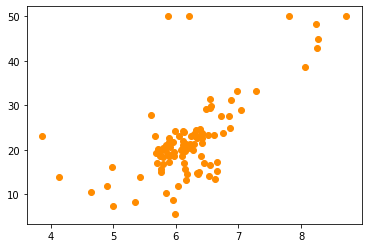

In [32]:
bostonDF_sample = df[['RM', 'TARGET']]
bostonDF_sample.rename(columns={'TARGET':'PRICE'}, inplace=True, errors='ignore')

# 100개를 샘플링으로 뽑아 데이터프레임 생성
bostonDF_sample = bostonDF_sample.sample(n= 100, random_state=0)
display(bostonDF_sample.shape)

plt.figure()
plt.scatter(bostonDF_sample['RM'], bostonDF_sample['PRICE'], c='darkorange')

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression

def get_dataset(df):
  """
  데이터프레임을 매개변수로 받아 피처와 레이블 데이터셋으로 분할하고, 테스트 데이터셋을 
  생성 후 ,피처, 레이블, 테스트 데이터셋을 리턴
  """
  # 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 셋 생성. 
  # 회귀선을 그리기 위해 사용
  X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

  # 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
  X_feature = df['RM'].values.reshape(-1, 1)
  y_target  = df['PRICE'].values.reshape(-1, 1)

  return X_feature, y_target, X_test

In [29]:
def lr_dt_regreassion(reg_models: list, X_feature, X_test, y_target):
  """
  1.선형회귀와 결정트리 기반으로 Regressor생성
  2.DecisionTreeRegressor의 max_depth는 각각 2와 7
  3.학습 및 예측 수행 후 예측값을 리스트로 리턴
  """
  preds_list = []

  # 학습과 예측 수행 후 예측값을 리스트 타입으로 리턴
  for model in reg_models:
    model.fit(X_feature, y_target)
    pred = model.predict(X_test)
    preds_list.append(pred)
  return preds_list

In [27]:
# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
X_feature, y_target, X_test = get_dataset(bostonDF_sample)
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)
models = [lr_reg, rf_reg2, rf_reg7]
preds_list = lr_dt_regreassion(models, X_feature, X_test, y_target)

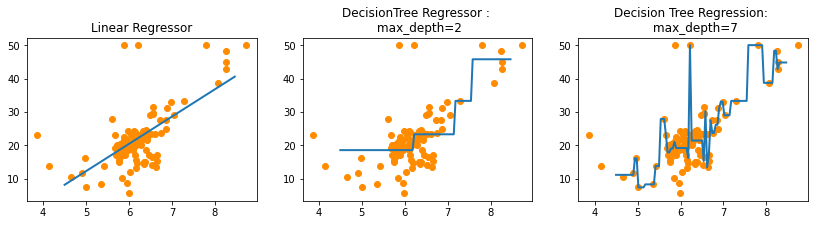

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 3), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title("Linear Regressor")
ax1.scatter(bostonDF_sample['RM'], bostonDF_sample['PRICE'], c='darkorange')
ax1.plot(X_test, preds_list[0], label='Linear', linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title("DecisionTree Regressor : \n max_depth=2")
ax2.scatter(bostonDF_sample['RM'], bostonDF_sample['PRICE'], c='darkorange')
ax2.plot(X_test, preds_list[1], label='max_depth:3', linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title("Decision Tree Regression: \n max_depth=7")
ax3.scatter(bostonDF_sample['RM'], bostonDF_sample['PRICE'], c='darkorange')
ax3.plot(X_test, preds_list[2], label='max_depth:7', linewidth=2)